In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

## Guide to Notebook 
* Section 1 contains the data preprocessing and feature engineering - understanding the dataset, removing NaNs, averaging to quarterly values, visualisation, creating new lagging features
* Section 2 contains basic linear regression
* Section 3 adds polynomial features and introduces a Lasso model 
* Section 4 tunes hyperparameters and introduces an ElasticNet model
* Section 5 one shot performance testing with best model

## Section 1 - pre-processing and feature engineering
There are no missing monthly values from 1958-2016 for EFFR, inflation and unemployment rate. All Additional NaNs are mid-month entries from when FF target rates were changed mid-month. FF Target rate was disregarded as this did not start until 1982.

Monthly values were averaged into quarterly values.
First few cells are I code to remove the NaNs before realising there already existed a pandas drop NaNs method, then a rolling average is performed by looping through the values, then some checks to ensure training samples match the correct dates.

In [2]:
df = pd.read_csv('index.csv')
df.head(10)

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN
5,1954,12,1,NaN,NaN,NaN,1.28,NaN,5.0,NaN
6,1955,1,1,NaN,NaN,NaN,1.39,11.9,4.9,NaN
7,1955,2,1,NaN,NaN,NaN,1.29,NaN,4.7,NaN
8,1955,3,1,NaN,NaN,NaN,1.35,NaN,4.6,NaN
9,1955,4,1,NaN,NaN,NaN,1.43,6.7,4.7,NaN


In [3]:
# remove NaNs from target var, y is evaluated quarterly (start of month 1,4,7,10)
y = df["Real GDP (Percent Change)"]
y_idx = []
y_clean = []

for i,j in enumerate(y):
    if not np.isnan(j):
        y_clean.append(j)
        y_idx.append(i)

# put back into a dataframe, indexed by the date as this is invariant throughout (position indices change as data is cleaned)
targ_df = df.iloc[y_idx][["Year", "Month", "Day"]]
targ_df.insert(3, "Real GDP (Percent Change)", y_clean)     
targ_df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])
targ_df.drop([0], inplace=True)
targ_df.set_index("Date", inplace=True)
targ_df.drop(columns=["Year", "Month", "Day"], inplace=True)
targ_df[0:5]

,Real GDP (Percent Change)
Date,
1954-10-01,8.0
1955-01-01,11.9
1955-04-01,6.7
1955-07-01,5.5
1955-10-01,2.4


In [4]:
X = df.drop(columns=["Real GDP (Percent Change)"])      # uncleaned feature matrix 
X["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])
X.set_index("Date", inplace=True)
X.drop(columns=["Year", "Month", "Day"], inplace=True)
X[337:342]

,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Unemployment Rate,Inflation Rate
Date,,,,,,
1982-08-01,NaN,NaN,NaN,10.12,9.8,7.1
1982-09-01,NaN,NaN,NaN,10.31,10.1,5.9
1982-09-27,10.25,NaN,NaN,NaN,NaN,NaN
1982-10-01,10.00,NaN,NaN,9.71,10.4,5.9
1982-10-07,9.50,NaN,NaN,NaN,NaN,NaN


In [5]:
# disregard all NaNs as these are mid-month terms
EFFR = []
EFFR_idx = []
for i,j in enumerate(X["Effective Federal Funds Rate"]):
    if not np.isnan(j):
        EFFR.append(j)
        EFFR_idx.append(X.index[i])

# create a df with EFFR values 
EFFR_df = pd.DataFrame({
                        "Date": EFFR_idx, 
                        "EFFR": EFFR})
EFFR_df.set_index("Date", inplace=True)         # make index the year so can reference it from target

# average the effective federal funds (EFFR) quarterly - use the 3 momths preceding the quarter nas this is how they will be predicted 
EFFR_mean = []
for i in targ_df.index:
    idx = EFFR_df.index.get_loc(i)
    EFFR_mean.append(np.mean([EFFR_df.iloc[idx-1]["EFFR"], EFFR_df.iloc[idx-2]["EFFR"], EFFR_df.iloc[idx-3]["EFFR"]]))

# some checks: 
idx = EFFR_df.index.get_loc(targ_df.index[200])
print(EFFR_df.iloc[idx].name == targ_df.index[200])
print(EFFR_df.iloc[idx-3].name == targ_df.index[200-1])
print(len(EFFR_mean) == len(targ_df))

True
True
True


In [6]:
feature_df = targ_df.copy()     # to keep date formatting
feature_df.drop(columns=["Real GDP (Percent Change)"], inplace=True)
feature_df.insert(0, "EFFR Mean", EFFR_mean)            # create feature matrix
feature_df[0:5]

,EFFR Mean
Date,
1954-10-01,1.026667
1955-01-01,0.986667
1955-04-01,1.343333
1955-07-01,1.500000
1955-10-01,1.940000


In [7]:
# now do the same for unemployment rate 
# disregard all NaNs as these are mid-month terms
unemploy= []
unemploy_idx = []
for i,j in enumerate(X["Unemployment Rate"]):
    if not np.isnan(j):
        unemploy.append(j)
        unemploy_idx.append(X.index[i])
    
# create a df with unemployment values 
unemploy_df = pd.DataFrame({
                        "Date": unemploy_idx, 
                        "Unemployment Rate": unemploy})
unemploy_df.set_index("Date", inplace=True)  

# average the effective federal funds (EFFR) quarterly - use the 3 momths preceding the quarter nas this is how they will be predicted 
unemploy_mean = []
for i in targ_df.index:
    idx = unemploy_df.index.get_loc(i)
    unemploy_mean.append(np.mean([unemploy_df.iloc[idx-1]["Unemployment Rate"], unemploy_df.iloc[idx-2]["Unemployment Rate"], unemploy_df.iloc[idx-3]["Unemployment Rate"]]))

# some checks: 
idx = unemploy_df.index.get_loc(targ_df.index[200])
print(unemploy_df.iloc[idx].name == targ_df.index[200])
print(unemploy_df.iloc[idx-3].name == targ_df.index[200-1])
print(len(unemploy_mean) == len(targ_df))


True
True
True


In [8]:
feature_df.insert(0, "Unemployment Rate Mean", unemploy_mean)
feature_df[0:5]

,Unemployment Rate Mean,EFFR Mean
Date,,
1954-10-01,5.966667,1.026667
1955-01-01,5.333333,0.986667
1955-04-01,4.733333,1.343333
1955-07-01,4.400000,1.500000
1955-10-01,4.100000,1.940000


In [9]:
# now do the same for inflation rate 
# disregard all NaNs as these are mid-month terms
# inflation rate data doesnt start until 1958 -> model 1 won't start until 1958

inflation= []
inflation_idx = []
for i,j in enumerate(X["Inflation Rate"]):
    if not np.isnan(j):
        inflation.append(j)
        inflation_idx.append(X.index[i])
    
# create a df with inflationment values 
inflation_df = pd.DataFrame({
                        "Date": inflation_idx, 
                        "Inflation Rate": inflation})
inflation_df.set_index("Date", inplace=True)  

# average the effective federal funds (EFFR) quarterly - use the 3 momths preceding the quarter nas this is how they will be predicted 
inflation_mean = []
inf_idx = []
for i in targ_df.index[targ_df.index.get_loc(inflation_df.index[0]):]:
    idx = inflation_df.index.get_loc(i)
    inf_idx.append(idx)
    inflation_mean.append(np.mean([inflation_df.iloc[idx-1]["Inflation Rate"], inflation_df.iloc[idx-2]["Inflation Rate"], inflation_df.iloc[idx-3]["Inflation Rate"]]))

# create dataframe for quarterly mean inflation rate 
inf_mean_df = pd.DataFrame({"Date": targ_df.index[targ_df.index.get_loc(inflation_df.index[0]):],
                            "Inflation Mean" : inflation_mean})
inf_mean_df.set_index("Date", inplace=True)

# some checks: 
idx = inflation_df.index.get_loc(targ_df.index[200])
print(inflation_df.iloc[idx].name == targ_df.index[200])
print(inflation_df.iloc[idx-3].name == targ_df.index[200-1])
print(len(inflation_mean) == len(targ_df))                  # expect this to be false as inflation data doesn't start until 1958 


True
True
False


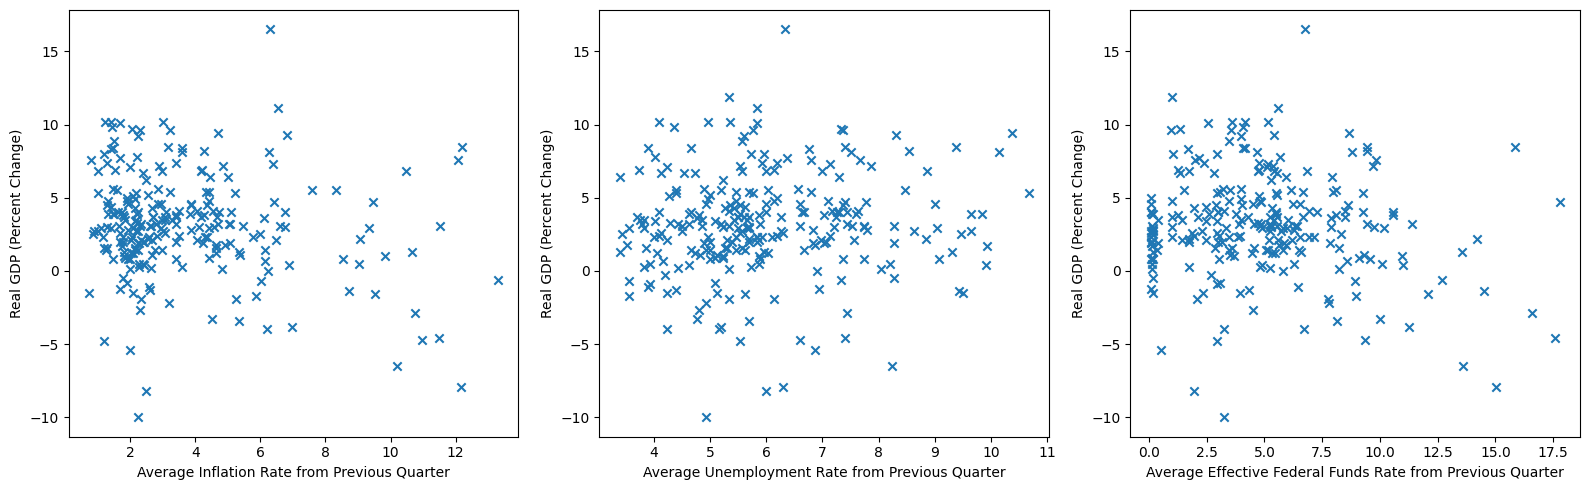

In [10]:
## Make Plots to check for relationships
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
target = targ_df["Real GDP (Percent Change)"]

axs[0].scatter(inf_mean_df["Inflation Mean"], targ_df["Real GDP (Percent Change)"].loc[inf_mean_df.index], marker='x')
axs[0].set_xlabel('Average Inflation Rate from Previous Quarter')
axs[0].set_ylabel('Real GDP (Percent Change)')

axs[1].scatter(feature_df['Unemployment Rate Mean'], target, marker='x')
axs[1].set_xlabel('Average Unemployment Rate from Previous Quarter')
axs[1].set_ylabel('Real GDP (Percent Change)')

axs[2].scatter(feature_df['EFFR Mean'], target, marker='x')
axs[2].set_xlabel('Average Effective Federal Funds Rate from Previous Quarter')
axs[2].set_ylabel('Real GDP (Percent Change)')

plt.tight_layout()
plt.show()

Very little clear correlation between features and target. Note, outliers.

## Feature Engineering 
Add prebvious quarters values for the last 4 quarters included for all features and the target

In [11]:
targ_df_M1 = pd.DataFrame(targ_df["Real GDP (Percent Change)"].loc[inf_mean_df.index].copy())
feature_df_M1 = pd.DataFrame(feature_df[["Unemployment Rate Mean", "EFFR Mean"]].loc[inf_mean_df.index].copy())
feature_df_M1.insert(1, "Inflation Mean", inf_mean_df["Inflation Mean"])
X_M1 = feature_df_M1
rand=25 
X_M1

,Unemployment Rate Mean,Inflation Mean,EFFR Mean
Date,,,
1958-01-01,4.933333,2.233333,3.253333
1958-04-01,6.300000,3.066667,1.863333
1958-07-01,7.366667,2.300000,0.940000
1958-10-01,7.333333,2.066667,1.323333
1959-01-01,6.366667,1.700000,2.163333
...,...,...,...
2015-10-01,5.100000,1.833333,0.136667
2016-01-01,5.000000,2.000000,0.160000
2016-04-01,4.933333,2.233333,0.360000


In [12]:
lags = [1,2,3]        # introduce lag features 
target = "Real GDP (Percent Change)"
predictors = ["EFFR Mean", "Inflation Mean", "Unemployment Rate Mean", target]  # include target to create its own lags as this could be informative
X_M1.insert(3, "Real GDP (Percent Change)", targ_df_M1["Real GDP (Percent Change)"])

In [13]:
for col in predictors:
    for L in lags:
        X_M1[f"{col}_lag{L}"] = X_M1[col].shift(L)

In [14]:
feature_cols = [c for c in X_M1.columns if c != target]       # create feature matrix w/o target
df_feat = X_M1.dropna(subset=feature_cols).copy()         # remove NaN columns
y_M1 = targ_df_M1.loc[df_feat.index].copy()                 # match lenths of feat and targs
print(len(y_M1) == len(df_feat))

True


In [15]:
df_feat.head(5)

,Unemployment Rate Mean,Inflation Mean,EFFR Mean,Real GDP (Percent Change),EFFR Mean_lag1,EFFR Mean_lag2,EFFR Mean_lag3,Inflation Mean_lag1,Inflation Mean_lag2,Inflation Mean_lag3,Unemployment Rate Mean_lag1,Unemployment Rate Mean_lag2,Unemployment Rate Mean_lag3,Real GDP (Percent Change)_lag1,Real GDP (Percent Change)_lag2,Real GDP (Percent Change)_lag3
Date,,,,,,,,,,,,,,,,
1958-10-01,7.333333,2.066667,1.323333,9.7,0.940000,1.863333,3.253333,2.300000,3.066667,2.233333,7.366667,6.300000,4.933333,9.6,2.6,-10.0
1959-01-01,6.366667,1.700000,2.163333,7.7,1.323333,0.940000,1.863333,2.066667,2.300000,3.066667,7.333333,7.366667,6.300000,9.7,9.6,2.6
1959-04-01,5.833333,1.700000,2.570000,10.1,2.163333,1.323333,0.940000,1.700000,2.066667,2.300000,6.366667,7.333333,7.366667,7.7,9.7,9.6
1959-07-01,5.100000,1.900000,3.083333,-0.8,2.570000,2.163333,1.323333,1.700000,1.700000,2.066667,5.833333,6.366667,7.333333,10.1,7.7,9.7
1959-10-01,5.266667,2.133333,3.576667,1.6,3.083333,2.570000,2.163333,1.900000,1.700000,1.700000,5.100000,5.833333,6.366667,-0.8,10.1,7.7


In [16]:
df_feat.drop(columns=["Real GDP (Percent Change)"], inplace=True)

In [17]:
len(df_feat.columns)

15

In [18]:
abs(df_feat.corrwith(y_M1["Real GDP (Percent Change)"])).sort_values(ascending=False)

Real GDP (Percent Change)_lag1    0.337243
Real GDP (Percent Change)_lag2    0.255074
Inflation Mean                    0.181704
EFFR Mean_lag1                    0.169700
Unemployment Rate Mean_lag2       0.144838
Inflation Mean_lag1               0.140700
EFFR Mean                         0.137986
Unemployment Rate Mean_lag3       0.133610
Unemployment Rate Mean_lag1       0.125255
EFFR Mean_lag2                    0.120606
EFFR Mean_lag3                    0.097588
Real GDP (Percent Change)_lag3    0.087404
Inflation Mean_lag2               0.081910
Inflation Mean_lag3               0.060475
Unemployment Rate Mean            0.052677
dtype: float64

Generally low correlation values, particularly in unemployment rate

# Section 2 - basic linear regression
 Features from 1958-2016, using lags, inflation rate , EFFR and unemployment rate

In [19]:
from sklearn.model_selection import train_test_split, KFold, cross_validate, learning_curve, RepeatedKFold, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

In [20]:
print(f"The stabndard deviation of the target var is: {y_M1.std().iloc[0]:.4f}")

The stabndard deviation of the target var is: 3.4579


In [21]:
reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=0.1, random_state=rand))])         # instantiate pipeline class, setting the scaler and model (ridge regression)

In [22]:
tss = TimeSeriesSplit(n_splits = 2)         # use time series train test split so we do not train on future data, no random_state as it never shuffles data

for train_index, test_index in tss.split(df_feat, y_M1):
    X_trainM1, X_testM1 = df_feat.iloc[train_index, :], df_feat.iloc[test_index,:]
    y_trainM1, y_testM1 = y_M1.iloc[train_index], y_M1.iloc[test_index]

In [23]:
X_trainM1.tail(3)

,Unemployment Rate Mean,Inflation Mean,EFFR Mean,EFFR Mean_lag1,EFFR Mean_lag2,EFFR Mean_lag3,Inflation Mean_lag1,Inflation Mean_lag2,Inflation Mean_lag3,Unemployment Rate Mean_lag1,Unemployment Rate Mean_lag2,Unemployment Rate Mean_lag3,Real GDP (Percent Change)_lag1,Real GDP (Percent Change)_lag2,Real GDP (Percent Change)_lag3
Date,,,,,,,,,,,,,,,
1997-01-01,5.333333,2.600000,5.280000,5.306667,5.243333,5.363333,2.666667,2.700000,2.900000,5.266667,5.500000,5.533333,4.3,3.7,7.2
1997-04-01,5.233333,2.500000,5.276667,5.280000,5.306667,5.243333,2.600000,2.666667,2.700000,5.333333,5.266667,5.500000,3.1,4.3,3.7
1997-07-01,5.000000,2.533333,5.523333,5.276667,5.280000,5.306667,2.500000,2.600000,2.666667,5.233333,5.333333,5.266667,6.2,3.1,4.3


In [24]:
X_testM1.head(3)

,Unemployment Rate Mean,Inflation Mean,EFFR Mean,EFFR Mean_lag1,EFFR Mean_lag2,EFFR Mean_lag3,Inflation Mean_lag1,Inflation Mean_lag2,Inflation Mean_lag3,Unemployment Rate Mean_lag1,Unemployment Rate Mean_lag2,Unemployment Rate Mean_lag3,Real GDP (Percent Change)_lag1,Real GDP (Percent Change)_lag2,Real GDP (Percent Change)_lag3
Date,,,,,,,,,,,,,,,
1997-10-01,4.866667,2.300000,5.533333,5.523333,5.276667,5.280000,2.533333,2.500000,2.600000,5.000000,5.233333,5.333333,5.2,6.2,3.1
1998-01-01,4.666667,2.233333,5.506667,5.533333,5.523333,5.276667,2.300000,2.533333,2.500000,4.866667,5.000000,5.233333,3.1,5.2,6.2
1998-04-01,4.633333,2.200000,5.520000,5.506667,5.533333,5.523333,2.233333,2.300000,2.533333,4.666667,4.866667,5.000000,4.0,3.1,5.2


No overlap -> model will only be trained on older data than it is tested - reflecting true predictive ability.

In [25]:
# initialise a time-series aware cross validation method 
cv_reg = cross_validate(
    reg_pipe, X_trainM1, y_trainM1, cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)

In [26]:
print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")

CV Mean R2 (train):  0.368 ± 0.047
CV Mean R2 (val):    -0.842  ± 0.253
CV Mean RMSE (val):  4.712
CV Mean MAE (val):   3.763


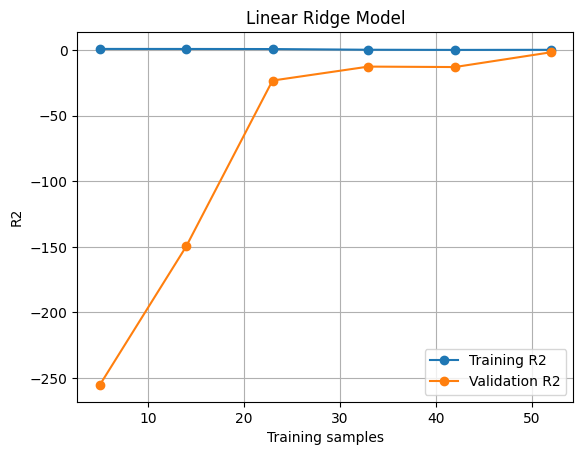

In [27]:
# Learning curve (Regression, R2)
train_sizes, train_scores, val_scores = learning_curve(
    reg_pipe, X_trainM1, y_trainM1, cv=tss, scoring="r2", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6), shuffle=False, random_state=rand)


plt.figure()
plt.title("Linear Ridge Model")
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Training R2")
plt.plot(train_sizes, val_scores.mean(axis=1), marker="o", label="Validation R2")
plt.xlabel("Training samples"); plt.ylabel("R2"); plt.legend(); plt.grid(True)
plt.show()

## Section 3 - using polynomial features 


In [28]:
from sklearn.compose import ColumnTransformer

### Ridge Regression Polynomial Model

CV Mean R2 (train):  0.528 ± 0.030
CV Mean R2 (val):    -1252.847  ± 1252.207
CV Mean RMSE (val):  121.542
CV Mean MAE (val):   83.720


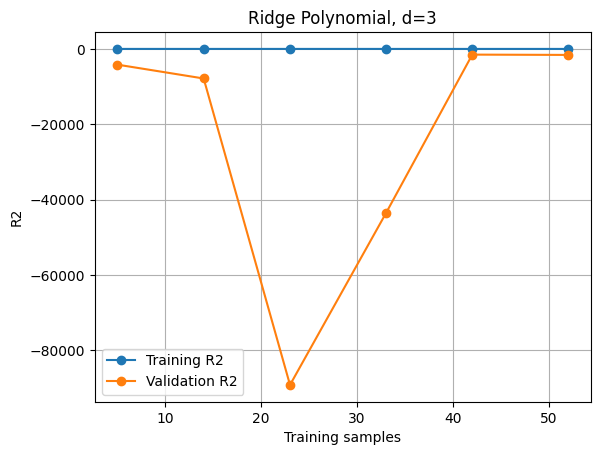

In [29]:
cols_poly = ["EFFR Mean", "Inflation Mean", "Unemployment Rate Mean"]        # only want to make non-lag features poly as reduces comp. cost and noise 
cols_lag  = [c for c in df_feat.columns if "lag" in c]

poly_features = PolynomialFeatures(degree=3, include_bias=False)        
scaler = StandardScaler()

ct = ColumnTransformer([("poly", Pipeline([("poly", poly_features), ("scaler", scaler)]), cols_poly), 
                       ("lag_scaler", scaler, cols_lag)])                                                    # column transformer only transforms the columns in cols_poly

pipe_M1 = Pipeline([
    ('ct', ct),
    ('ridge', Ridge(alpha=0.01))])       # implement column trabsformer into a new pipeline


cv_reg = cross_validate(
    pipe_M1, X_trainM1, y_trainM1, cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)

print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")


train_sizes, train_scores, val_scores = learning_curve(
    pipe_M1, X_trainM1, y_trainM1, cv=tss, scoring="r2", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6), shuffle=False, random_state=rand)


plt.figure()
plt.title("Ridge Polynomial, d=3")
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Training R2")
plt.plot(train_sizes, val_scores.mean(axis=1), marker="o", label="Validation R2")
plt.xlabel("Training samples"); plt.ylabel("R2"); plt.legend(); plt.grid(True)
plt.show()

Does not generalise well for degree 3 ridge polynomial and small regularisation

### Lasso Regression Polynomial Model
Lasso encourages some coefficients to go to zero - effectiuvely acting as feature selection. This is particulary useful in this degree=3 polynomial fit as there is {x_many} features, many of which may be uninformative or contribute noise to the true relationship

CV Mean R2 (train):  0.316 ± 0.029
CV Mean R2 (val):    -0.488  ± 0.065
CV Mean RMSE (val):  4.087
CV Mean MAE (val):   3.256


/Users/frase/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e-02, tolerance: 9.841e-03
  model = cd_fast.enet_coordinate_descent(
/Users/frase/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e-02, tolerance: 9.841e-03
  model = cd_fast.enet_coordinate_descent(


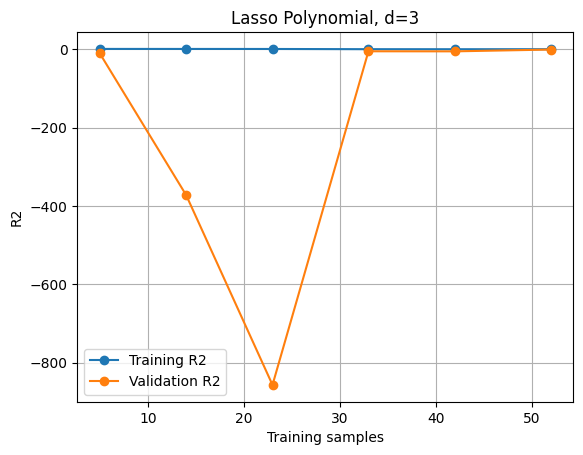

In [30]:
cols_poly = ["EFFR Mean", "Inflation Mean", "Unemployment Rate Mean"]        # only want to make non-lag features poly as reduces comp. cost and noise 
cols_lag  = [c for c in df_feat.columns if "lag" in c]

poly_features = PolynomialFeatures(degree=3, include_bias=False)        
scaler = StandardScaler()

ct = ColumnTransformer([("poly", Pipeline([("poly", poly_features), ("scaler", scaler)]), cols_poly), 
                       ("lag_scaler", scaler, cols_lag)])                                                    # column transformer only transforms the columns in cols_poly

pipe_M1 = Pipeline([
    ('ct', ct),
    ('lasso', Lasso(alpha=0.1))])       # implement column trabsformer into a new pipeline

cv_reg = cross_validate(
    pipe_M1, X_trainM1, y_trainM1, cv=tss, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True)

print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")


train_sizes, train_scores, val_scores = learning_curve(
    pipe_M1, X_trainM1, y_trainM1, cv=tss, scoring="r2", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6), shuffle=False, random_state=rand)


plt.figure()
plt.title("Lasso Polynomial, d=3")
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Training R2")
plt.plot(train_sizes, val_scores.mean(axis=1), marker="o", label="Validation R2")
plt.xlabel("Training samples"); plt.ylabel("R2"); plt.legend(); plt.grid(True)
plt.show()

Lasso generalises much better, likley due to the feature selection characteristic resulting in the model not fitting to noise to the same extent.  

## Section 4 - Hyperparameter Tuning

In [31]:
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp

### Ridge Optimisation

In [32]:
ct = ColumnTransformer([("poly", Pipeline([("poly", poly_features), ("scaler", scaler)]), cols_poly), 
                       ("lag_scaler", scaler, cols_lag)])                                                    # column transformer only transforms the columns in cols_poly

pipe_tune = Pipeline([
    ('ct', ct),
    ('ridge', Ridge(random_state=rand))])       # implement column trabsformer into a new pipeline

param_grid = {'ct__poly__poly__degree': sp.stats.randint(1,13), 'ridge__alpha': sp.stats.loguniform(1e-4, 1e4)}        # dictionary of params, use distributions to reduyce compute with randomsearch_ridge
t0 = time.time()

search_ridge = RandomizedSearchCV(pipe_tune, param_grid, n_iter=300, scoring='r2', cv=tss, n_jobs=2, refit=True, return_train_score=False, verbose=1, random_state=rand)
search_ridge.fit(X_trainM1, y_trainM1)
search_ridge_time = time.time() - t0
results = search_ridge.cv_results_

Fitting 2 folds for each of 300 candidates, totalling 600 fits


In [33]:
print(f"Search time: {search_ridge_time*1000:.1f} ms")
cv = pd.DataFrame(search_ridge.cv_results_)
cv['alpha'] = cv['param_ridge__alpha']
cv['degree'] = cv['param_ct__poly__poly__degree']


cv_top = cv.sort_values('mean_test_score', ascending=False).head(5)    # show the best 5
cv_top[['degree','alpha','mean_test_score','std_test_score']]

Search time: 2510.0 ms


,degree,alpha,mean_test_score,std_test_score
284,1,497.277877,0.057686,0.116399
299,1,312.886915,0.057325,0.147328
61,1,547.537066,0.056212,0.110453
265,3,2028.765147,0.055353,0.147640
16,1,251.749092,0.052592,0.162871


**Note:** The dataframe has columns titled with test score, though the cv set was used.

Best params: alpha=497.2779, degree=1
Best CV R2: 0.0577 ± 0.1164
The train scores are: [0.091 0.137 0.078 0.057 0.123]
The val scores are: [-0.584  0.111  0.092 -0.021  0.045]


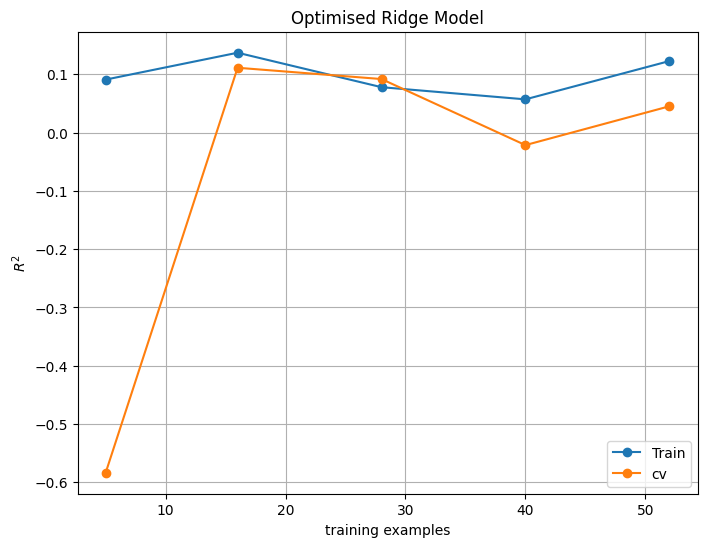

In [34]:
train_sizes, train_scores, val_scores = learning_curve(search_ridge.best_estimator_, X_trainM1, y_trainM1,
    cv=tss, scoring='r2', n_jobs=1, shuffle=False)


best_ridge = search_ridge.best_estimator_
print(f"Best params: alpha={search_ridge.best_params_['ridge__alpha']:.4f}, degree={search_ridge.best_params_['ct__poly__poly__degree']}")
print(f"Best CV R2: {search_ridge.best_score_:.4f} ± {cv_top['std_test_score'].iloc[0]:.4f}")

print(f"The train scores are: {np.round(train_scores.mean(axis=1), 3)}")
print(f"The val scores are: {np.round(val_scores.mean(axis=1), 3)}")

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train')
ax.plot(train_sizes, val_scores.mean(axis=1), marker='o', label='cv')
ax.set_xlabel('training examples')
ax.set_ylabel('$R^2$')
ax.set_title('Optimised Ridge Model')
ax.legend()
ax.grid()
plt.show()

## Lasso Optimistion
Advantages of Lasso: prefersd solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. We expect this to be useful as some of our features are likely to be multicollinear

In [35]:
pipe_tune = Pipeline([
    ('ct', ct),
    ('ridge', Lasso(random_state=rand))])

param_grid = {'ct__poly__poly__degree': sp.stats.randint(1,13), 'ridge__alpha': sp.stats.loguniform(1e-4, 1e4)}        # dictionary of params
t0 = time.time()

search_lasso = RandomizedSearchCV(pipe_tune, param_grid, n_iter=300, scoring='r2', cv=tss, n_jobs=2, refit=True, return_train_score=False, verbose=1, random_state=rand)
search_lasso.fit(X_trainM1, y_trainM1)
search_lasso_time = time.time() - t0
results = search_lasso.cv_results_

Fitting 2 folds for each of 300 candidates, totalling 600 fits


/Users/frase/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.386e+01, tolerance: 7.494e-02
  model = cd_fast.enet_coordinate_descent(
/Users/frase/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.751e+02, tolerance: 7.494e-02
  model = cd_fast.enet_coordinate_descent(
/Users/frase/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

In [36]:
print(f"Search time: {search_lasso_time*1000:.1f} ms")
cv = pd.DataFrame(search_lasso.cv_results_)
cv['alpha'] = cv['param_ridge__alpha']
cv['degree'] = cv['param_ct__poly__poly__degree']


cv_top = cv.sort_values('mean_test_score', ascending=False).head(5)    # show the best 5
cv_top[['degree','alpha','mean_test_score','std_test_score']]

Search time: 2340.7 ms


,degree,alpha,mean_test_score,std_test_score
55,7,1.141222,0.060845,0.116091
125,7,1.152349,0.060249,0.114441
68,5,0.985536,0.058686,0.138399
285,2,1.175976,0.058294,0.111269
269,8,1.211699,0.054741,0.106150


Best params: alpha=1.1412, degree=7
Best CV R2: 0.0608 ± 0.1161
The train scores are: [0.735 0.677 0.098 0.007 0.102]
The val scores are: [-5.81118e+02 -6.95290e+02 -1.98950e+01 -3.36000e-01  7.10000e-02]


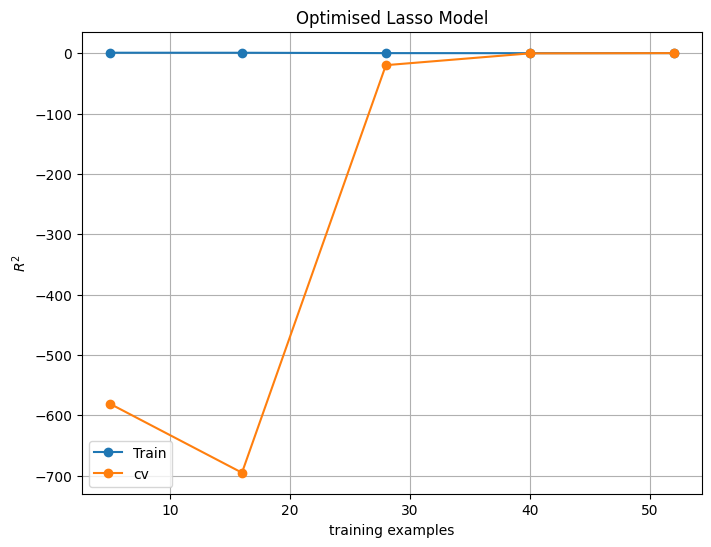

In [37]:
train_sizes, train_scores, val_scores = learning_curve(search_lasso.best_estimator_, X_trainM1, y_trainM1,
    cv=tss, scoring='r2', n_jobs=1, shuffle=False)


best_lasso = search_lasso.best_estimator_
print(f"Best params: alpha={search_lasso.best_params_['ridge__alpha']:.4f}, degree={search_lasso.best_params_['ct__poly__poly__degree']}")
print(f"Best CV R2: {search_lasso.best_score_:.4f} ± {cv_top['std_test_score'].iloc[0]:.4f}")

print(f"The train scores are: {np.round(train_scores.mean(axis=1), 3)}")
print(f"The val scores are: {np.round(val_scores.mean(axis=1), 3)}")

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train')
ax.plot(train_sizes, val_scores.mean(axis=1), marker='o', label='cv')
ax.set_xlabel('training examples')
ax.set_ylabel('$R^2$')
ax.set_title('Optimised Lasso Model')
ax.legend()
ax.grid()
plt.show()

### Elastic Net Optimisation
A combination of L1 and L2 regularisation

In [38]:
pipe_tune = Pipeline([
    ('ct', ct),
    ('model', ElasticNet(random_state=rand))])

param_grid = {'ct__poly__poly__degree': sp.stats.randint(1,13), 'model__alpha': sp.stats.loguniform(1e-4, 1e4), 'model__l1_ratio': sp.stats.uniform(0, 1)}        # dictionary of params
t0 = time.time()

search_en = RandomizedSearchCV(pipe_tune, param_grid, n_iter=500, scoring='r2', cv=tss, n_jobs=2, refit=True, return_train_score=False, verbose=1, random_state=rand)
search_en.fit(X_trainM1, y_trainM1)
search_en_time = time.time() - t0
results = search_en.cv_results_

Fitting 2 folds for each of 500 candidates, totalling 1000 fits


/Users/frase/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.304e+02, tolerance: 7.494e-02
  model = cd_fast.enet_coordinate_descent(
/Users/frase/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.653e+02, tolerance: 1.978e-01
  model = cd_fast.enet_coordinate_descent(
/Users/frase/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

In [39]:
print(f"Search time: {search_en_time*1000:.1f} ms")
cv = pd.DataFrame(search_en.cv_results_)
cv['alpha'] = cv['param_model__alpha']
cv['degree'] = cv['param_ct__poly__poly__degree']
cv['l1 ratio'] = cv['param_model__l1_ratio']


cv_top = cv.sort_values('mean_test_score', ascending=False).head(5)    # show the best 5
cv_top[['degree','alpha','l1 ratio','mean_test_score','std_test_score']]

Search time: 4158.5 ms


,degree,alpha,l1 ratio,mean_test_score,std_test_score
35,7,1.141222,0.775050,0.085420,0.178791
325,7,2.471034,0.424973,0.072697,0.149217
306,9,1.586150,0.687283,0.069961,0.136724
482,1,1.429594,0.495946,0.061703,0.133542
154,4,0.762593,0.913407,0.056194,0.212546


Best params: alpha=1.1412, degree=7, l1 ratio= 0.7751
Best CV R2: 0.0854 ± 0.1788
The train scores are: [0.756 0.684 0.141 0.049 0.131]
The val scores are: [-1.6602752e+04 -1.1300360e+03 -3.2346000e+01 -5.3700000e-01
  8.5000000e-02]


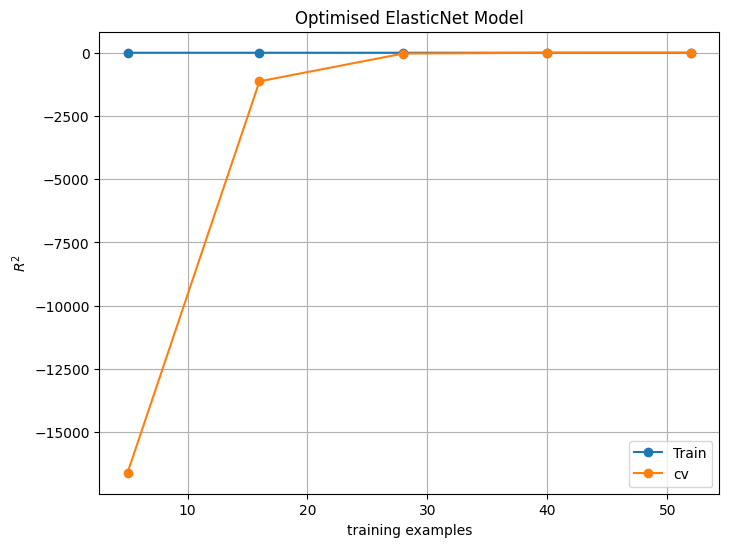

In [40]:
train_sizes, train_scores, val_scores = learning_curve(search_en.best_estimator_, X_trainM1, y_trainM1,
    cv=tss, scoring='r2', n_jobs=1, shuffle=False)

best_en = search_en.best_estimator_
print(f"Best params: alpha={search_en.best_params_['model__alpha']:.4f}, degree={search_en.best_params_['ct__poly__poly__degree']}, l1 ratio= {search_en.best_params_['model__l1_ratio']:.4f}")
print(f"Best CV R2: {search_en.best_score_:.4f} ± {cv_top['std_test_score'].iloc[0]:.4f}")

print(f"The train scores are: {np.round(train_scores.mean(axis=1), 3)}")
print(f"The val scores are: {np.round(val_scores.mean(axis=1), 3)}")

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train')
ax.plot(train_sizes, val_scores.mean(axis=1), marker='o', label='cv')
ax.set_xlabel('training examples')
ax.set_ylabel('$R^2$')
ax.set_title('Optimised ElasticNet Model')
ax.legend()
ax.grid()
plt.show()

Try with less features to see if they are just adding noise: 

In [41]:
cols_keep = ['EFFR Mean',
 'Inflation Mean',  
 'EFFR Mean_lag1',
 'Inflation Mean_lag1',
 'Real GDP (Percent Change)_lag1']

In [42]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)        
scaler = StandardScaler()

ct = ColumnTransformer([("poly", Pipeline([("poly", poly_features), ("scaler", scaler)]), cols_keep)])   

X_train_new = X_trainM1[cols_keep].copy()

pipe_tune = Pipeline([
    ('ct', ct),
    ('model', ElasticNet(random_state=rand))])

param_grid = {'ct__poly__poly__degree': sp.stats.randint(1,9), 'model__alpha': sp.stats.loguniform(1e-4, 1e4), 'model__l1_ratio': sp.stats.uniform(0, 1)}        # dictionary of params
t0 = time.time()

search_small = RandomizedSearchCV(pipe_tune, param_grid, n_iter=400, scoring='r2', cv=tss, n_jobs=2, refit=True, return_train_score=False, verbose=1, random_state=rand)
search_small.fit(X_train_new, y_trainM1)
search_small_time = time.time() - t0
results = search_small.cv_results_

print(f"Search time: {search_small_time*1000:.1f} ms")
cv = pd.DataFrame(search_small.cv_results_)
cv['alpha'] = cv['param_model__alpha']
cv['degree'] = cv['param_ct__poly__poly__degree']
cv['l1 ratio'] = cv['param_model__l1_ratio']


cv_top = cv.sort_values('mean_test_score', ascending=False).head(5)    # show the best 5
cv_top[['degree','alpha','l1 ratio','mean_test_score','std_test_score']]

Fitting 2 folds for each of 400 candidates, totalling 800 fits


/Users/frase/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.009e+01, tolerance: 7.494e-02
  model = cd_fast.enet_coordinate_descent(
/Users/frase/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.531e+02, tolerance: 1.978e-01
  model = cd_fast.enet_coordinate_descent(
/Users/frase/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

Search time: 4690.4 ms


/Users/frase/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.299e+02, tolerance: 1.978e-01
  model = cd_fast.enet_coordinate_descent(
/Users/frase/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.046e-01, tolerance: 7.494e-02
  model = cd_fast.enet_coordinate_descent(
/Users/frase/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

,degree,alpha,l1 ratio,mean_test_score,std_test_score
304,1,1.006224,0.753462,0.069293,0.127436
78,1,0.892082,0.533438,0.061859,0.110113
387,1,4.841630,0.059777,0.060751,0.098192
305,1,0.837232,0.972816,0.059482,0.136953
384,1,0.739106,0.675542,0.055133,0.111134


Best params: alpha=1.0062, degree=1, l1 ratio= 0.7535
Best CV R2: 0.0693 ± 0.1274
The train scores are: [0.57  0.413 0.106 0.053 0.134]
The val scores are: [-5.5497e+01 -1.1138e+01 -5.2400e-01  3.7000e-02  7.7000e-02]


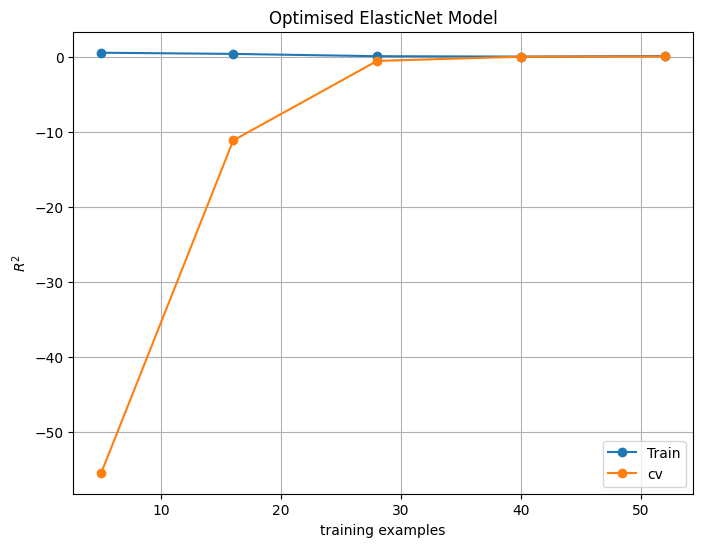

In [43]:
train_sizes, train_scores, val_scores = learning_curve(search_small.best_estimator_, X_trainM1, y_trainM1,
    cv=tss, scoring='r2', n_jobs=1, shuffle=False)

best_en_small = search_small.best_estimator_
print(f"Best params: alpha={search_small.best_params_['model__alpha']:.4f}, degree={search_small.best_params_['ct__poly__poly__degree']}, l1 ratio= {search_small.best_params_['model__l1_ratio']:.4f}")
print(f"Best CV R2: {search_small.best_score_:.4f} ± {cv_top['std_test_score'].iloc[0]:.4f}")

print(f"The train scores are: {np.round(train_scores.mean(axis=1), 3)}")
print(f"The val scores are: {np.round(val_scores.mean(axis=1), 3)}")

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train')
ax.plot(train_sizes, val_scores.mean(axis=1), marker='o', label='cv')
ax.set_xlabel('training examples')
ax.set_ylabel('$R^2$')
ax.set_title('Optimised ElasticNet Model')
ax.legend()
ax.grid()

Performance is similar

## Section 5 - one shot performance test

In [44]:
 # Test on the held out dataset for final reporting
t0 = time.time()
y_pred = best_en.predict(X_testM1)
t_pred = time.time() - t0
rmse = (root_mean_squared_error(y_testM1, y_pred))
mae = mean_absolute_error(y_testM1, y_pred)
r2 = r2_score(y_testM1, y_pred)
print(f"Test RMSE: {rmse:.3f} | Test MAE: {mae:.3f} | Test R2: {r2:.3f}")

Test RMSE: 3.313 | Test MAE: 2.549 | Test R2: -0.749


In [49]:
print(f"Prediction time on test set:  {t_pred*1000:.1f} ms")
print(f"The standard deviation on the test set is: {y_testM1.std().iloc[0]:.4f}")

Prediction time on test set:  4.3 ms
The standard deviation on the test set is: 2.5214
